# Cancer Classification from RNA-Seq Gene Expression

---
embed-resources: true
echo: false
---

## Introduction

Early and accurate cancer detection is quite a challenge in today's medicine, as earlier diagnosis is closely linked to improved patient outcomes. Advancements in next-generation sequencing have made measuring gene expression increasingly accessible, providing a downstream view of how genetic variation works at the molecular level. In this project, I will be measuring whether RNA sequence gene expression data can support a proof-of-concept multi-class cancer classification model capable of distinguishing between several clinically defined cancer types. The goal is not to produce a clinically deployable system, but instead evaluate whether sufficient predictive signal exists to justify further development. Using gene expression data derived from The Cancer Genome Atlas, this task is phrased as supervised learning problem and assesses model performance using metrics that emphasize balanced performance across cancer types, while carefully analyzing misclassification patterns and their potential implications.

## Methods

In [12]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



I chose a logistic regression because it works well in settings where there are many more features than observations, which is typical for gene expression data. With 2,000 gene expression measurements per sample, a regularized linear model give a good balance between capturing meaningful signal and avoiding overfitting. Logistic regression is also computationally efficient and relatively easy to unerstand, making it the essential choice for an early proof-of-concept analysis rather than a fully deployed clinical model. For evaluation, I used the macro-averaged F-beta score with β = 1, which balances precision and recall while weighting each cancer type equally. This metric was chosen instead of accuracy alone because it avoids better performance on one cancer type from hiding worse performance on others and provides a clearer picture of how the model behaves across all classes.

### Data

In [19]:
# load data
genetics = pd.read_parquet(
    "https://lab.cs307.org/genetics/data/genetics.parquet",
)
X = genetics.drop("cancer", axis=1)
y = genetics["cancer"]


### Variable Descriptions
##### Response

**`cancer`**

- `[object]` the clinically determined cancer type, one of:
    - `BRCA`: Breast Invasive Carcinoma
    - `PRAD`: Prostate Adenocarcinoma
    - `KIRC`: Kidney Renal Clear Cell Carcinoma
    - `LUAD`: Lung Adenocarcinoma
    - `COAD`: Colon Adenocarcinoma

##### Features

**`gene_####`**

- `[float64]` gene expression (for gene number `####` in the dataset) quantification as measured by an [Illumina HiSeq](https://www.illumina.com/content/dam/illumina-support/documents//products/datasheets/datasheet_hiseq_systems.pdf) platform

The data used in this analysis was derived from The Cancer Genome Atlas (TCGA) Pan-Cancer Analysis Project and accessed through a modified dataset provided for CS 307. Each observation corresponds to a tissue sample from a cancer patient and includes RNA-Seq gene expression measurements quantified using an Illumina HiSeq platform. The response variable is the clinically determined cancer type, while the features consist of expression values for 2,000 genes. This curated dataset was designed to support exploratory and proof-of-concept modeling rather than direct clinical deployment.



In [ ]:
# summary statistics
cancer_brac = genetics[genetics["cancer"] == "BRCA"]
cancer_prad = genetics[genetics["cancer"] == "PRAD"]
cancer_kirc = genetics[genetics["cancer"] == "KIRC"]
cancer_luad = genetics[genetics["cancer"] == "LUAD"]
cancer_coad = genetics[genetics["cancer"] == "COAD"]

# Example: summary statistics for BRCA gene expression
cancer_brac.drop(columns="cancer").describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_3990,gene_3991,gene_3992,gene_3993,gene_3994,gene_3995,gene_3996,gene_3997,gene_3998,gene_3999
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.0,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.011362,2.839739,2.805759,6.692613,10.003743,0.0,7.503838,0.499902,0.021714,0.031654,...,0.231045,10.466370,10.469238,8.385704,11.091545,4.194613,1.542750,7.147200,9.819015,5.765469
std,0.102185,1.170290,0.957401,0.594704,0.489907,0.0,1.059361,0.477072,0.156161,0.326046,...,0.737538,0.504273,0.614452,0.562645,0.525339,2.118735,1.473651,0.986159,0.604328,1.184463
min,0.000000,0.000000,0.000000,5.009284,8.674496,0.0,4.302421,0.000000,0.000000,0.000000,...,0.000000,9.422904,8.260727,6.164430,9.349471,0.000000,0.000000,3.310791,7.599534,2.657571
25%,0.000000,2.181478,2.258534,6.312547,9.695073,0.0,6.815214,0.000000,0.000000,0.000000,...,0.000000,10.106890,10.062909,8.049496,10.772287,2.779375,0.366419,6.619483,9.460001,4.965664
50%,0.000000,2.979628,2.818643,6.651307,9.971637,0.0,7.469176,0.429213,0.000000,0.000000,...,0.000000,10.373403,10.464178,8.400885,11.075826,4.068843,1.236679,7.203934,9.829169,5.753800
75%,0.000000,3.679492,3.431634,7.033325,10.289796,0.0,8.100619,0.782533,0.000000,0.000000,...,0.000000,10.784285,10.823750,8.733666,11.410137,5.507197,2.458569,7.835513,10.192955,6.545570
max,1.482332,5.774405,5.229730,10.129528,11.355621,0.0,10.696255,2.342697,1.785592,4.067604,...,7.779522,12.596232,12.576770,10.055730,12.875431,11.574338,6.263953,9.778503,11.193827,9.051484


The dataset consists of gene expression measurements for 2,000 genes across tissue samples from five cancer types: BRCA, PRAD, KIRC, LUAD, and COAD. Each cancer subtype contains a comparable number of observations, resulting in a reasonably balanced multi-class classification problem. Summary statistics calculated separately by cancer type shows a large variation in gene expression levels both within and across cancer categories, with many genes exhibiting skewed distributions and differing ranges. These differences suggest that gene expression profiles contain meaningful signal that may be useful for distinguishing between cancer types, emphasizing the use of supervised classification models.

<Figure size 800x600 with 0 Axes>

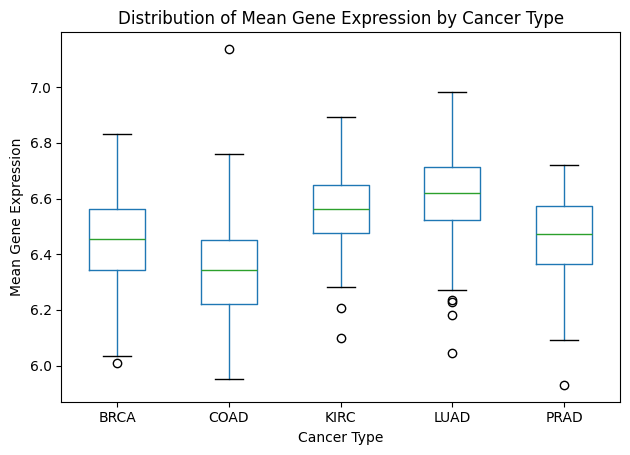

In [ ]:
# exploratory visualization
genetics["Mean Gene Expression"] = genetics.drop(columns="cancer").mean(axis=1)


plt.figure(figsize=(8, 6))

genetics.boxplot(
    column="Mean Gene Expression",
    by="cancer",
    grid=False
)

plt.xlabel("Cancer Type")
plt.ylabel("Mean Gene Expression")
plt.title("Distribution of Mean Gene Expression by Cancer Type")
plt.suptitle("") 
plt.tight_layout()
plt.show()


This figure summarizes the distribution of mean gene expression values across cancer types. While substantial overlap are present, differences in median expression levels and variability are present between cancers such as LUAD, KIRC, and COAD. These systematic shifts suggest that gene expression profiles capture biologically meaningful differences across cancer types, motivating the use of supervised classification models.

### Models

In [ ]:
# process data for ML
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=78
)


In [15]:
#train model
base_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        max_iter=3000,
        random_state=78
    ))
])

param_grid = {"clf__C": [0.01, 0.1, 1, 10]}

fbeta_macro = make_scorer(
    fbeta_score,
    beta=1.0,
    average="macro",
    zero_division=0
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=fbeta_macro,
    cv=3,
    n_jobs=1
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

To train the cancer classification model, I constructed a preprocessing and modeling pipeline that treated all gene expression measurements as numerical features and standardized them to ensure consistent scaling across genes. These preprocessing steps were integrated with a multinomial logistic regression classifier inside a unified scikit-learn pipeline, allowing feature transformation and model fitting to be performed seamlessly within a single workflow. I used GridSearchCV with cross-validation to tune the model’s regularization strength, which controls the tradeoff between model complexity and stability in a high-dimensional setting. The grid search identified the best-performing hyperparameter configuration, and the final model was then refit using the full training dataset to produce the model used for downstream analysis.

## Results

In [16]:
# report model metrics
print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Test Macro F-beta (β=1):", round(fbeta_score(y_test, y_pred, beta=1.0, average="macro"), 3))
print(classification_report(y_test, y_pred))

Best Parameters: {'clf__C': 0.01}
Test Accuracy: 1.0
Test Macro F-beta (β=1): 1.0
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



The macro-averaged F-beta score with β = 1 was chosen as the primary test metric because it balances precision and recall while weighting each cancer type equally. In a multi-class cancer classification setting, overall accuracy alone can obscure poor performance on individual cancer types, particularly if class sizes differ. By averaging performance across all classes, the macro-averaged F-beta score provides a more informative and fair assessment of model performance and ensures that strong results for one cancer type do not mask weaker performance for others.

The final multinomial logistic regression model selected a regularization strength of 
𝐶=0.01 through cross-validation. On the test set, the model achieved a test accuracy of 1.00 and a macro-averaged F-beta score (β = 1) of 1.00. Precision, recall, and F1-score were equal to 1.00 for each cancer type (BRCA, COAD, KIRC, LUAD, and PRAD). The test set consisted of 161 observations, all of which were correctly classified.

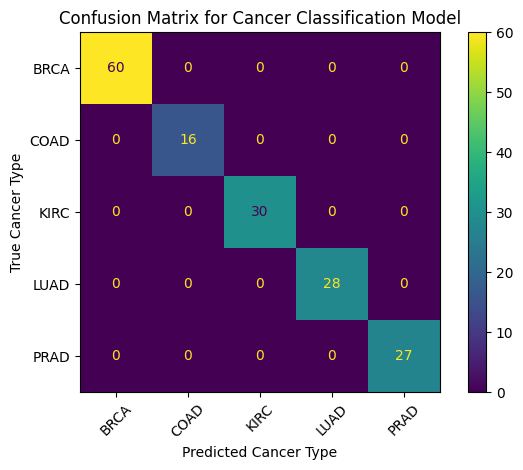

In [17]:
# summary figure
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(
    y_test,
    y_pred,
    labels=model.named_steps["clf"].classes_
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.named_steps["clf"].classes_
)

disp.plot(xticks_rotation=45)
plt.xlabel("Predicted Cancer Type")
plt.ylabel("True Cancer Type")
plt.title("Confusion Matrix for Cancer Classification Model")
plt.tight_layout()
plt.show()

The confusion matrix displays the counts of predicted and true cancer types for the test dataset. For BRCA samples, 60 observations were correctly predicted as BRCA. For COAD samples, 16 observations were correctly predicted as COAD. For KIRC samples, 30 observations were correctly predicted as KIRC. For LUAD samples, 28 observations were correctly predicted as LUAD. For PRAD samples, 27 observations were correctly predicted as PRAD. All off-diagonal cells contain zero values, indicating that no observations were predicted as an incorrect cancer type.

In [21]:
#serialize model
from joblib import dump
dump(model, "cancer_model.joblib", compress=7)

['cancer_model.joblib']

## Discussion

The results of this analysis demonstrate that the RNA-Seq gene expression data contains strong signal for distinguishing between the five cancer types provided in this study. The selected multinomial logistic regression model achieved perfect performance on the held-out test set, correctly classifying all test samples across cancer categories. These results suggest that, within the context of the provided dataset, gene expression profiles are highly informative for multi-class cancer classification and that a relatively simple, regularized linear model is sufficient to capture this structure.

Despite these strong results, this model should not be used directly in practice in its current form. The data used in this project were drawn from a curated research cohort, and both training and test samples originate from the same underlying distribution. Hence, the observed performance may likely overestimate real-world generalization, where additional sources of variation like batch effects, technical noise, population heterogeneity, and differences in sequencing platforms would be present. In a clinical or production setting, these factors could lead to misclassifications that are not acounted for in the controlled evaluation performed here.

If further development was done on this model, several improvements would be necessary before considering real-world use. These include validation on independent external datasets, explicit correction for batch effects, evaluation on a broader range of cancer subtypes, and assessing model calibration to ensure predicted class probabilities are meaningful for later stage decision-making. Additionally, collaboration with domain experts would be required to understand the clinical consequences of specific misclassification errors. Overall, while this analysis supports the feasibility of gene expression–based cancer classification as a proof of concept, significant additional work would be required to translate this approach into a reliable and deployable system.